In [1]:
import pandas as pd
import numpy as np
import torch
import nltk
import re
import faiss
import ast
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
df = pd.read_csv('all_papers_country.csv')
df

,Id,Year,Title,journal_abbr,Abstract,Author Keywords,Loc,Country,Abstract_no_locations
0,273,1999,Multisensor remote sensing data for land use/c...,CEUS,Spaceborne radar data have only recently been ...,Land use/cover mapping; Multisensor; Radar; Se...,['East African'],['East Africa'],Spaceborne radar data have only recently been ...
1,278,1999,Geometric accessibility and geographic informa...,CEUS,Accessibility indices which measure the relati...,Accessibility; ArcView Extension; Desktop GIS;...,['French'],['France'],Accessibility indices which measure the relati...
2,289,1999,An object-based approach to a road network def...,CEUS,This paper describes a conceptual model for a ...,Accident database; Road accidents; Road network,['UK'],['United Kingdom'],This paper describes a conceptual model for a ...
3,292,1999,The geographic information system of the Turin...,CEUS,This paper gives a general introduction to the...,Geographical Information System; GIS; Internet...,['Turin'],['Italy'],This paper gives a general introduction to the...
4,293,1999,Internet mapping for dissemination of statisti...,CEUS,City and regional administrations find increas...,Cities; Internet; Mapping; Statistical informa...,"['Tilburg', 'Bonn']","['Germany', 'Netherlands']",City and regional administrations find increas...
...,...,...,...,...,...,...,...,...,...
2102,6587,2012,"Natural protected areas of San Luis Potos¨ª, M...",IJGIS,Assessments of the conservation status of natu...,altitudinal steps; conservation planning; ecor...,['San Luis Potos a'],['Mexico'],Assessments of the conservation status of natu...
2103,6761,2014,Effects of climate change and urban developmen...,IJGIS,Climate and land-use changes are projected to ...,climate change; Mediterranean type ecosystem; ...,['California Floristic Province'],['United States'],Climate and land-use changes are projected to ...
2104,7549,1996,Labeling map polygons using remote sensing: Ca...,JGS,Decision rules for assigning map labels to pol...,Decision rules; Map labeling; Remote sensing,['the Plumas National Forest'],['United States'],Decision rules for assigning map labels to pol...
2105,7706,2004,Web-based analytical tools for the exploration...,JGS,This paper deals with the extension of interne...,Exploratory spatial data analysis; Geotools; I...,['U.S.counties'],['United States'],This paper deals with the extension of interne...


## Compute embeddings

In [3]:
def generate_scibert_embeddings(df, batch_size=8):
    # Load SciBERT model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
    model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
    
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    embeddings = []
    embeddings_no_loc = []
    
    # Process regular abstracts
    print("Processing regular abstracts...")
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df['Abstract'].iloc[i:i + batch_size].tolist()
        
        encoded = tokenizer(batch_texts,
                          padding=True,
                          truncation=True,
                          max_length=512,
                          return_tensors='pt')
        
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(batch_embeddings)

    # Process no-location abstracts
    print("Processing no-location abstracts...")
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df['Abstract_no_locations'].iloc[i:i + batch_size].tolist()
        
        encoded = tokenizer(batch_texts,
                          padding=True,
                          truncation=True,
                          max_length=512,
                          return_tensors='pt')
        
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings_no_loc.extend(batch_embeddings)
    
    # Add both embedding columns
    df['Context_E'] = embeddings
    df['Context_E_no_loc'] = embeddings_no_loc
    
    return df

In [4]:
df = generate_scibert_embeddings(df)

2025-02-17 00:25:19.175314: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 00:25:19.183161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 00:25:19.193301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 00:25:19.196374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 00:25:19.204534: I tensorflow/core/platform/cpu_feature_guar

Processing regular abstracts...


100%|██████████| 264/264 [00:06<00:00, 40.10it/s]


Processing no-location abstracts...


100%|██████████| 264/264 [00:06<00:00, 39.70it/s]


In [5]:
# explode the country column
df['Country'] = df['Country'].apply(ast.literal_eval)
df_country = df.explode('Country')

In [6]:
# explode the keyword column
def preprocess(df):
    df['Year'] = df['Year'].astype(int)
    df['Author Keywords'] = df['Author Keywords'].str.lower().str.split(';')

   # Convert all keywords to lowercase and strip leading/trailing whitespaces
    df['Author Keywords'] = df['Author Keywords'].apply(lambda x: [kw.strip() for kw in x])
    df_expanded = df.explode('Author Keywords')

    return df_expanded

df_keywords = preprocess(df_country)
df_keywords = df_keywords.reset_index(drop=True)

In [7]:
replacements = {
    'colour': 'color',
    'crowd-sourcing': 'crowdsourcing',
    'generalisation':'generalization',
    'modeling': 'model',
    'modelling': 'model',
    'neighbourhood': 'neighborhood',
    'optimisation': 'optimization',
    'organisation': 'organization',
    'spatio': 'spatial',
    'spatiotemporal':'spatial temporal',
    'urbanisation': 'urbanization',
    'visualisation': 'visualization',
    'geographical':'geographic'
}

manual_mapping = {
    'abm': 'agent based model',
    'ai': 'artificial intelligence',
    'ais': 'artificial immune system',
    'ann': 'artificial neural network',
    'bim': 'building information model',
    'cad': 'computer aided design',
    'ca': 'cellular automata',
    'dca': 'detrended correspondence analysis',
    'dem': 'digital elevation model',
    'giscience': 'geographic information science',
    'gps': 'global positioning system',
    'gwr': 'geographically weighted regression',
    'kde': 'kernel density estimation',
    'luti': 'land use transport interaction',
    'mclp':'maximal covering location problem',
    'sdi': 'spatial data infrastructure',
    'svm': 'support vector machine',
    'vgi': 'volunteered geographic information',
    'www': 'world wide web'
}

# Define a list of exceptions that should not be lemmatized
exceptions = {'gis'}

lemmatizer = nltk.WordNetLemmatizer()

def preprocess_keyword(keyword, replacements, exceptions):
    # Remove everthing after the comma
    keyword = keyword.split(',')[0].strip()

    # Remove everything inside parentheses
    keyword = re.sub(r'\s*\(.*?\)', '', keyword)

    # Replace hyphens with spaces
    keyword = re.sub(r'[\-]', ' ', keyword)

    # Apply replacements and manual mappings
    words = keyword.split()
    replaced_words = [replacements.get(word, word) for word in words]
    combined_phrase = ' '.join(replaced_words)
    normalized_phrase = manual_mapping.get(combined_phrase, combined_phrase)

     # Lemmatize each word, except for those in the exceptions list
    lemmatized_words = [lemmatizer.lemmatize(word) if word not in exceptions else word for word in normalized_phrase.split()]

    return ' '.join(lemmatized_words)

In [8]:
df_keywords['Author Keywords'] = df_keywords['Author Keywords'].apply(lambda x: preprocess_keyword(x, replacements, exceptions))

In [9]:
# update the embedding for the keywords in the same year and country
def aggregate_keyword_embeddings(df):
    
    # First compute averaged embeddings for each Year-Country-Keyword combination
    grouped = df.groupby(['Year', 'Country', 'Author Keywords']).agg({
        'Context_E': lambda x: np.mean(np.vstack(x), axis=0),
        'Context_E_no_loc': lambda x: np.mean(np.vstack(x), axis=0)
    }).reset_index()
    
    # Create a dictionary for quick lookup of averaged embeddings
    embedding_dict = {}
    for _, row in grouped.iterrows():
        key = (row['Year'], row['Country'], row['Author Keywords'])
        embedding_dict[key] = (row['Context_E'], row['Context_E_no_loc'])
    
    # Create a copy of original dataframe
    df_result = df.copy()
    
    # Update embeddings for all matching rows
    for key, (avg_context_e, avg_context_e_no_loc) in embedding_dict.items():
        year, country, keyword = key
        mask = (df_result['Year'] == year) & \
               (df_result['Country'] == country) & \
               (df_result['Author Keywords'] == keyword)
        
        # Update one row at a time to handle numpy arrays correctly
        for idx in df_result[mask].index:
            df_result.at[idx, 'Context_E'] = avg_context_e
            df_result.at[idx, 'Context_E_no_loc'] = avg_context_e_no_loc
    
    return df_result

In [10]:
df_aggregated = aggregate_keyword_embeddings(df_keywords)

In [11]:
# reorganize and drop duplicates
def select_and_deduplicate(df):

    # Drop duplicates based on these three columns and then select all desired columns
    df_unique = df.drop_duplicates(subset=['Author Keywords', 'Year', 'Country'])[
        ['Author Keywords', 'Year', 'Country', 'Context_E', 'Context_E_no_loc']
    ]
    
    print(f"Original shape: {df.shape}")
    print(f"After selecting columns and dropping duplicates: {df_unique.shape}")
    
    return df_unique

In [12]:
df_final = select_and_deduplicate(df_aggregated)

Original shape: (12642, 11)
After selecting columns and dropping duplicates: (12146, 5)


In [13]:
def add_keyword_embeddings(df, batch_size=8):
    
    # Load SciBERT model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
    model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
    
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    embeddings = []
    
    # Process keywords in batches
    for i in tqdm(range(0, len(df), batch_size)):
        batch_texts = df['Author Keywords'].iloc[i:i + batch_size].tolist()
        
        # Tokenize
        encoded = tokenizer(batch_texts,
                          padding=True,
                          truncation=True,
                          max_length=512,
                          return_tensors='pt')
        
        # Move to GPU
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        
        # Generate embeddings
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            # Use [CLS] token embedding as the text embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(batch_embeddings)
    
    # Add embeddings as new column
    df['Text_E'] = embeddings
    
    return df

In [14]:
results_all_embeddings = add_keyword_embeddings(df_final)

100%|██████████| 1519/1519 [00:05<00:00, 262.10it/s]


In [15]:
results_all_embeddings

,Author Keywords,Year,Country,Context_E,Context_E_no_loc,Text_E
0,land use/cover mapping,1999,East Africa,"[2.2930126, -1.1735182, -0.44984877, 0.0478544...","[2.319932, -1.140013, -0.4880958, 0.08211336, ...","[0.6377058, 0.13946487, 0.5880917, 0.26834676,..."
1,multisensor,1999,East Africa,"[2.2930126, -1.1735182, -0.44984877, 0.0478544...","[2.319932, -1.140013, -0.4880958, 0.08211336, ...","[-0.13874398, 0.21458437, -0.16045055, -0.2951..."
2,radar,1999,East Africa,"[2.2930126, -1.1735182, -0.44984877, 0.0478544...","[2.319932, -1.140013, -0.4880958, 0.08211336, ...","[0.17842336, 0.5292052, -0.010547957, -0.44968..."
3,sensor fusion,1999,East Africa,"[2.2930126, -1.1735182, -0.44984877, 0.0478544...","[2.319932, -1.140013, -0.4880958, 0.08211336, ...","[0.45349014, 0.5260881, -0.36290377, -0.615465..."
4,texture,1999,East Africa,"[2.2930126, -1.1735182, -0.44984877, 0.0478544...","[2.319932, -1.140013, -0.4880958, 0.08211336, ...","[0.09459759, 0.9171124, -0.18723783, -0.766760..."
...,...,...,...,...,...,...
12637,spatial outlier,2004,United States,"[0.26129603, -0.51864123, 0.39303863, -0.59332...","[0.15503538, -0.37288076, -0.17918746, -0.4634...","[-0.27662504, 0.46227902, 0.048838574, -0.1479..."
12638,food environment,2017,Canada,"[-0.25282803, -0.19340907, -0.042038288, -0.02...","[-0.18689275, -0.11383285, -0.22889604, 0.1335...","[-0.3204867, -0.54151475, 0.4688162, 0.0544157..."
12639,geographic information system,2017,Canada,"[-0.25282803, -0.19340907, -0.042038288, -0.02...","[-0.18689275, -0.11383285, -0.22889604, 0.1335...","[-0.3159914, -0.014802803, 0.09981839, -0.2445..."
12640,socioeconomic position,2017,Canada,"[-0.25282803, -0.19340907, -0.042038288, -0.02...","[-0.18689275, -0.11383285, -0.22889604, 0.1335...","[-0.692851, 0.31460056, -1.1007245, 0.30578774..."


In [16]:
input_df = results_all_embeddings.copy()

def normalize_embedding(embedding):
    return normalize(np.array(embedding).reshape(1, -1))[0]

# normalize embeddings
input_df['n_Context_E'] = input_df['Context_E'].apply(normalize_embedding)
input_df['n_Context_E_no_loc'] = input_df['Context_E_no_loc'].apply(normalize_embedding)
input_df['n_Text_E'] = input_df['Text_E'].apply(normalize_embedding)

In [19]:
def get_top_n_countries(df, n=10):
    top_10 = df['Country'].value_counts().nlargest(n).index.tolist()
    filtered_df = df[df['Country'].isin(top_10)].copy()
    return filtered_df

top_10_df = get_top_n_countries(concept_rep)

## Location vs. no Location by Country

In [17]:
from collections import defaultdict

def analyze_country_sensitivity(df, min_keyword_count=100):
    
    df['cosine_distance'] = np.array([
        1 - np.dot(e1, e2) 
        for e1, e2 in zip(df['n_Context_E'], df['n_Context_E_no_loc'])
    ])
    
    # Group by country
    grouped = df.groupby('Country')['cosine_distance'].agg(['mean', 'std', 'count']).reset_index()
    
    # Sort by mean sensitivity
    result = (grouped[grouped['count'] >= min_keyword_count]
             .sort_values('mean', ascending=False)
             .reset_index(drop=True))
    return result

In [18]:
sensitivity_df = analyze_country_sensitivity(input_df)
print(sensitivity_df.head(20))  

           Country      mean       std  count
0            Japan  0.019042  0.017538    235
1           Taiwan  0.014726  0.012253    113
2            China  0.013589  0.013343   1622
3          Austria  0.013572  0.013122    107
4        Australia  0.013375  0.012809    406
5            India  0.012510  0.014436    169
6            Spain  0.011284  0.012918    323
7           Brazil  0.011177  0.008972    132
8         Portugal  0.011015  0.007313    126
9      Switzerland  0.010763  0.007982    151
10           Italy  0.010694  0.009131    285
11          Canada  0.010335  0.012981    485
12          Sweden  0.010180  0.007473    118
13  United Kingdom  0.008969  0.009873    942
14            Iran  0.008681  0.005223    145
15   United States  0.008423  0.009306   2729
16         Belgium  0.008305  0.006248    124
17         Germany  0.008145  0.006737    346
18          France  0.008089  0.005790    276
19          Greece  0.007804  0.005795    144


In [46]:
def get_sensitivity_df(df):
    filtered_df = df[df['Country'].isin(sensitivity_df['Country'].unique())].copy()
    return filtered_df

In [47]:
sense_df = get_sensitivity_df(input_df)

In [54]:
# Perform a permutation test to determine if the difference between embeddings 
# with and without locations for a country is significantly different from random.
def permutation_test_country(df, country_name, n_permutations=1000):
    
    import numpy as np
    
    # Filter for the specific country
    country_df = df[df['Country'] == country_name]
    
    if len(country_df) == 0:
        return {"error": f"No data found for country: {country_name}"}
    
    # Compute actual cosine distances
    actual_distances = np.array([
        1 - np.dot(e1, e2) 
        for e1, e2 in zip(country_df['n_Context_E'], country_df['n_Context_E_no_loc'])
    ])
    
    # Compute actual mean distance
    actual_mean_dist = np.mean(actual_distances)
    
    # Permutation test
    permuted_means = []
    embeddings_with_loc = np.array(list(country_df['n_Context_E']))
    embeddings_no_loc = np.array(list(country_df['n_Context_E_no_loc']))
    
    for _ in range(n_permutations):
        # Randomly shuffle one of the embedding sets
        shuffled_idx = np.random.permutation(len(embeddings_with_loc))
        shuffled_no_loc = embeddings_no_loc[shuffled_idx]
        
        # Compute distances with shuffled pairs
        permuted_distances = np.array([
            1 - np.dot(e1, e2) 
            for e1, e2 in zip(embeddings_with_loc, shuffled_no_loc)
        ])
        
        permuted_means.append(np.mean(permuted_distances))
    
    # Compute p-value
    # (proportion of permuted means that are as extreme as or more extreme than actual mean)
    p_value = 2 * min(
    np.mean(permuted_means <= actual_mean_dist),  # how often random is smaller
    np.mean(permuted_means >= actual_mean_dist)   # how often random is larger
    )
    
    return {
        "country": country_name,
        "sample_size": len(actual_distances),
        "actual_mean_distance": actual_mean_dist,
        "permutation_mean": np.mean(permuted_means),
        "permutation_std": np.std(permuted_means),
        "p_value": p_value,
        "significant": p_value < 0.05,
        "n_permutations": n_permutations
    }

In [59]:
single_country_result = permutation_test_country(sense_df, "Japan")
print(single_country_result)

{'country': 'Japan', 'sample_size': 235, 'actual_mean_distance': 0.019042074426691584, 'permutation_mean': 0.24086331099195685, 'permutation_std': 0.0037431904702048832, 'p_value': 0.0, 'significant': True, 'n_permutations': 1000}


In [56]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm  

def permutation_test(df, n_permutations=1000):
    # Calculate actual mean cosine distance
    actual_distances = np.array([
        1 - np.dot(e1, e2) 
        for e1, e2 in zip(df['n_Context_E'], df['n_Context_E_no_loc'])
    ])
    actual_mean = np.mean(actual_distances)
    
    # Permutation test
    permuted_means = np.zeros(n_permutations)
    embeddings_no_loc = np.stack(df['n_Context_E_no_loc'].values)
    
    for i in tqdm(range(n_permutations)):
        # Shuffle the no_loc embeddings
        permuted_embeddings = embeddings_no_loc[np.random.permutation(len(embeddings_no_loc))]
        
        # Calculate distances with permuted embeddings
        permuted_distances = np.array([
            1 - np.dot(e1, e2)
            for e1, e2 in zip(df['n_Context_E'], permuted_embeddings)
        ])
        permuted_means[i] = np.mean(permuted_distances)
    
    # Calculate p-value
    p_value = 2 * min(
    np.mean(permuted_means <= actual_mean),  # how often random is smaller
    np.mean(permuted_means >= actual_mean)   # how often random is larger
    )
    
    return {
        'actual_mean': actual_mean,
        'permutation_mean': np.mean(permuted_means),
        'permutation_std': np.std(permuted_means),
        'p_value': p_value
    }

In [57]:
permutation_test(sense_df, n_permutations=1000)

100%|██████████| 1000/1000 [00:23<00:00, 42.38it/s]


{'actual_mean': 0.010190437347091666,
 'permutation_mean': 0.242162106979251,
 'permutation_std': 0.000468218190821703,
 'p_value': 0.0}

## Location vs. no Location by Keyword

In [19]:
# Analyze keyword sensitivity to location removal using cosine dissimilarity
def analyze_location_sensitivity(df, min_count):
   
    # Compute cosine dissimilarity for each row
    df['dissimilarity'] = 1 - np.array([
        cosine_similarity([row.n_Context_E], [row.n_Context_E_no_loc])[0][0] 
        for _, row in df.iterrows()
    ])
    
    # Group by keyword and compute statistics
    keyword_stats = df.groupby('Author Keywords').agg({
        'dissimilarity': ['mean', 'std', 'count']
    }).round(4)
    
    # Flatten column names and filter by count
    keyword_stats.columns = ['avg_dissimilarity', 'std_dissimilarity', 'count']
    keyword_stats = keyword_stats[keyword_stats['count'] >= min_count]
    
    # Sort by average dissimilarity
    keyword_stats = keyword_stats.sort_values('avg_dissimilarity', ascending=False)
    
    return keyword_stats

In [32]:
keywords_loc = analyze_location_sensitivity(input_df,min_count=10)

In [33]:
word_cloud_df = keywords_loc[:10]
word_cloud_df.reset_index(inplace=True)
word_cloud_df

,Author Keywords,avg_dissimilarity,std_dissimilarity,count
0,regionalization,0.0278,0.0329,12
1,lidar,0.0170,0.0167,14
2,landscape metric,0.0166,0.0147,13
3,spatial planning,0.0165,0.0204,13
4,classification,0.0161,0.0210,21
5,clustering,0.0160,0.0169,12
6,europe,0.0160,0.0094,13
7,kernel density estimation,0.0159,0.0213,11
8,spatial data mining,0.0156,0.0211,15
9,land cover change,0.0155,0.0111,10


In [55]:
from wordcloud import WordCloud

def generate_wordcloud(df):
    
    # Create word frequency dictionary
    word_freqs = dict(zip(df['Author Keywords'], df['count']))
    
    # Generate word cloud
    wc = WordCloud(width=800, height=400,background_color='white',prefer_horizontal=0.7).generate_from_frequencies(word_freqs)
    
    # Display
    plt.figure(figsize=(8, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    
    return plt

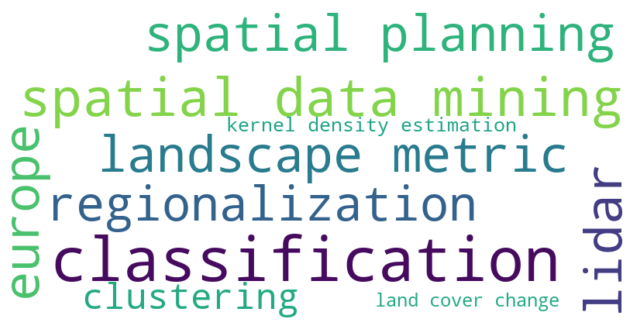

In [56]:
fig = generate_wordcloud(word_cloud_df)
fig.savefig('keyword_cloud_loc.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# get keyword count statistics
keyword_counts = results_all_embeddings.groupby(['Author Keywords']).size().reset_index(name='count')
keyword_counts = keyword_counts.sort_values(by='count', ascending=False)[:10]
keywords = keyword_counts['Author Keywords']
keyword_counts

,Author Keywords,count
2006,gis,138
1902,geographic information system,72
562,cellular automaton,63
2724,land use,55
4865,spatial analysis,54
4265,remote sensing,48
126,agent based model,48
5830,urban planning,47
5776,urban growth,45
3196,model,41


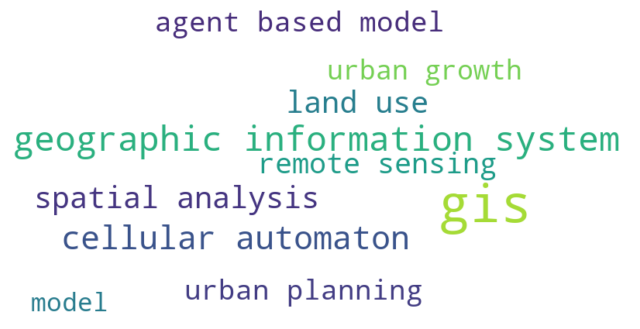

In [61]:
fig = generate_wordcloud(keyword_counts)
fig.savefig('keyword_cloud_all.png', dpi=300, bbox_inches='tight')
plt.show()

## Cluster and alpha selection

In [58]:
# test on cluster results with different alpha
def print_cluster_keywords(df, alpha, n_keywords=5):
    # Combine embeddings
    combined = alpha * np.array(df['n_Text_E'].tolist()) + \
              (1-alpha) * np.array(df['n_Context_E'].tolist())
    
    # Cluster
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
    labels = clusterer.fit_predict(combined)
    
    # Print top keywords for each cluster
    for cluster in set(labels):
        if cluster != -1:
            cluster_keywords = df[labels == cluster]['Author Keywords'].tolist()
            print(f"\nCluster {cluster} top keywords:")
            print(", ".join(cluster_keywords[:n_keywords]))

#print_cluster_keywords(input_df, 0.3, n_keywords=5)

In [19]:
alpha = 0.3
input_df['Combined_E'] = input_df.apply(lambda x: alpha * x['n_Text_E'] + (1-alpha) * x['n_Context_E'], axis=1)

concept_rep = input_df[['Year','Country','Author Keywords','Combined_E']]
concept_rep

,Year,Country,Author Keywords,Combined_E
0,1999,East Africa,land use/cover mapping,"[0.07471262, -0.032194104, -0.0054063397, 0.00..."
1,1999,East Africa,multisensor,"[0.064566575, -0.031104293, -0.015202061, -0.0..."
2,1999,East Africa,radar,"[0.06889031, -0.026738051, -0.013179338, -0.00..."
3,1999,East Africa,sensor fusion,"[0.07238862, -0.027103214, -0.017794192, -0.00..."
4,1999,East Africa,texture,"[0.067694575, -0.021848656, -0.015515989, -0.0..."
...,...,...,...,...
12637,2004,United States,spatial outlier,"[0.004365201, -0.009813843, 0.012723774, -0.02..."
12638,2017,Canada,food environment,"[-0.012062626, -0.013115069, 0.0048430646, -1...."
12639,2017,Canada,geographic information system,"[-0.012011563, -0.006206253, 5.2030664e-06, -0..."
12640,2017,Canada,socioeconomic position,"[-0.016667105, -0.0020120642, -0.015300617, 0...."


## hdbscan clustering

In [ ]:
# Function to perform HDBSCAN clustering
def cluster_embeddings(combined_embeddings, min_cluster_size=5, min_samples=10):

    embeddings_array = np.array(combined_embeddings['Combined_E'].tolist())

    # Perform HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(embeddings_array)

    # Add cluster labels to the DataFrame
    combined_embeddings['Cluster'] = clusterer.labels_

    return combined_embeddings

In [ ]:
top_10_df_cluster = cluster_embeddings(filtered_top_10)
top_10_df_cluster['Cluster'].unique()

In [ ]:
top_10_df_tsne = top_10_df_cluster[top_10_df_cluster['Cluster'] != -1]
top_10_df_tsne

## t-SNE Visualization

In [218]:
# Filter for specific years
selected_years = [2000, 2005, 2010, 2015, 2020]
filtered_top_10 = top_10_df[top_10_df['Year'].isin(selected_years)]

/tmp/ipykernel_944597/1075733800.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_944597/1075733800.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



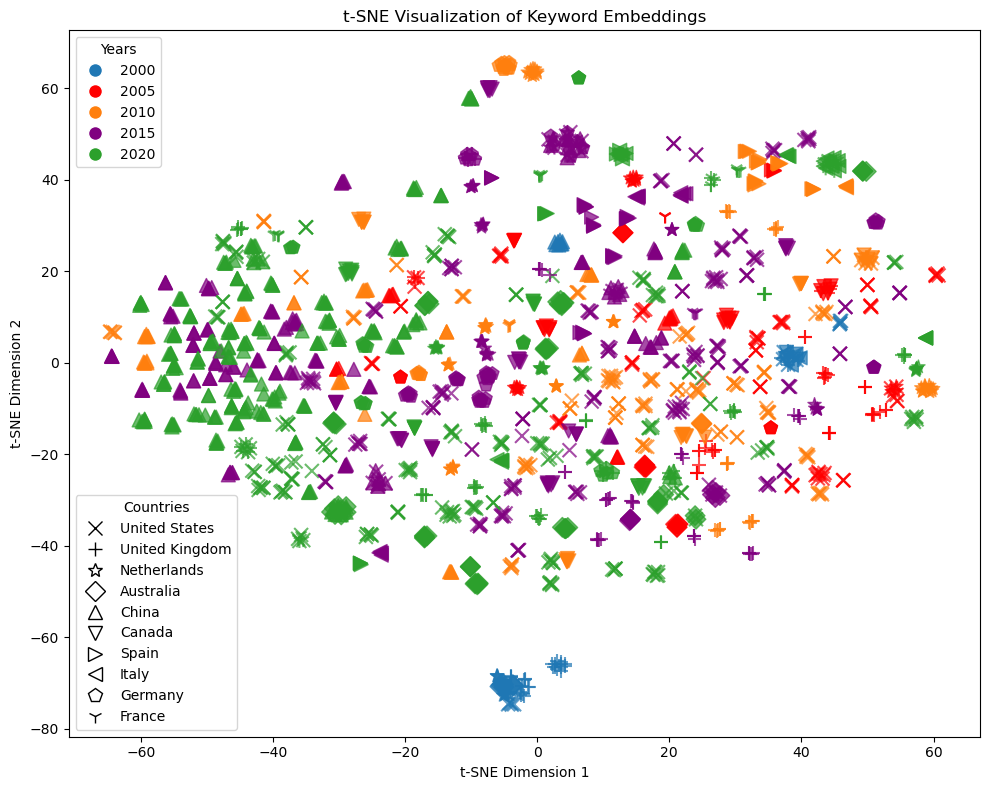

In [221]:
# Apply t-SNE to your embeddings
from matplotlib.lines import Line2D
input_df_tsne = filtered_top_10

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(np.array(input_df_tsne['Combined_E'].tolist()))
input_df_tsne['x'] = embeddings_2d[:, 0]
input_df_tsne['y'] = embeddings_2d[:, 1]

# Create the plot
plt.figure(figsize=(10, 8))
plt.subplots_adjust(right=0.85) 

# Define markers for countries and colors for years
markers = ['x', '+', '*', 'D', '^', 'v', '>', '<', 'p', '1'] 
year_colors = {2000: '#1f77b4', 2005: '#ff0000', 2010: '#ff7f0e', 2015:'#800080', 2020: '#2ca02c'}  # distinct colors for each year
countries = input_df_tsne['Country'].unique()

# Store scatter plot objects for country legend
country_scatters = []

# Plot each country separately to maintain marker types
for country, marker in zip(countries, markers):
    mask = input_df_tsne['Country'] == country
    years = input_df_tsne.loc[mask, 'Year']
    colors = [year_colors[y] for y in years]
    
    scatter = plt.scatter(input_df_tsne.loc[mask, 'x'], 
                         input_df_tsne.loc[mask, 'y'],
                         c=colors,
                         marker=marker,
                         s=100,
                         alpha=0.7,
                         label=country)
    
# Create legend elements for countries (black markers only)
country_legend_elements = [Line2D([0], [0], marker=marker, color='w', 
                                markeredgecolor='black', markersize=10,
                                label=country, linestyle='none')
                         for marker, country in zip(markers, countries)]

# Create custom legend for years
year_legend_elements = [Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=color, label=str(year), markersize=10)
                       for year, color in year_colors.items()]

# Add both legends
first_legend = plt.legend(handles=country_legend_elements, title='Countries', 
                         bbox_to_anchor=(0, 0), loc='lower left')
plt.gca().add_artist(first_legend)
plt.legend(handles=year_legend_elements, title='Years', 
          bbox_to_anchor=(0, 1), loc='upper left')

# Add title and labels
plt.title('t-SNE Visualization of Keyword Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.savefig('tsne.png',dpi=300)
plt.show()

## semantic trajectory

In [20]:
def analyze_keyword_coverage(df):
    
    # Group by keyword and calculate statistics
    keyword_stats = df.groupby('Author Keywords').agg({
        'Year': lambda x: f"{x.min()}-{x.max()} ({x.max() - x.min()} years)",  # Year range and span
        'Country': lambda x: len(x.unique()),   # Unique countries
        'Combined_E': 'count'                   # Total occurrences
    })
    
    # Extract time span number from the Year string
    keyword_stats['time_span'] = keyword_stats['Year'].str.extract(r'\((\d+) years\)').astype(int)
    
    # Rename columns for clarity
    keyword_stats = keyword_stats.rename(columns={
        'Country': 'unique_countries',
        'Combined_E': 'total_occurrences'
    })
    
    # Add number of unique years for reference
    keyword_stats['unique_years'] = df.groupby('Author Keywords')['Year'].nunique()
    
    # Calculate coverage score (time span × unique countries)
    keyword_stats['coverage_score'] = keyword_stats['time_span'] * keyword_stats['unique_countries']
    
    # Sort by coverage score in descending order
    keyword_stats_sorted = keyword_stats.sort_values('coverage_score', ascending=False)
    
    # Reorder columns to match desired sequence and reset index to make Keywords a column
    final_df = keyword_stats_sorted.reset_index().rename(columns={'Author Keywords': 'Keyword'})
    
    # Select and reorder columns
    final_df = final_df[['Keyword', 'Year', 'unique_years', 'unique_countries', 
                        'total_occurrences', 'coverage_score']]
    
    # Rename columns to match LaTeX format if needed
    final_df = final_df.rename(columns={
        'Year': 'Time Span',
        'unique_years': 'Unique Years',
        'unique_countries': 'Unique Countries',
        'total_occurrences': 'Occurrence',
        'coverage_score': 'Coverage Score'
    })
    
    return final_df

In [21]:
keyword_coverage = analyze_keyword_coverage(concept_rep)
keyword_coverage.head(10)

,Keyword,Time Span,Unique Years,Unique Countries,Occurrence,Coverage Score
0,gis,1993-2020 (27 years),26,45,138,1215
1,geographic information system,1994-2020 (26 years),20,36,72,936
2,remote sensing,1995-2020 (25 years),17,29,48,725
3,land use,1995-2020 (25 years),20,26,55,650
4,model,1999-2020 (21 years),12,28,41,588
5,urban planning,1998-2020 (22 years),15,25,47,550
6,spatial analysis,1998-2020 (22 years),18,25,54,550
7,cellular automaton,2000-2020 (20 years),19,25,63,500
8,visualization,1997-2019 (22 years),14,20,39,440
9,cadastre,2001-2020 (19 years),8,20,24,380


In [20]:
top_10_df = get_top_n_countries(concept_rep)

In [67]:
from sklearn.decomposition import PCA

# Alternative version using matplotlib:
def plot_keyword_trajectory_matplotlib(df, keyword):
    """
    Alternative version using matplotlib for static plots
    """
    keyword_data = df[df['Author Keywords'] == keyword].copy()
    embeddings = np.stack(keyword_data['Combined_E'].values)
    
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    keyword_data['PC1'] = embeddings_2d[:, 0]
    keyword_data['PC2'] = embeddings_2d[:, 1]
    
    plt.figure(figsize=(10, 8))
    
    for country in keyword_data['Country'].unique():
        country_data = keyword_data[keyword_data['Country'] == country].sort_values('Year')
        plt.plot(country_data['PC1'], country_data['PC2'], 'o-', label=country)
        
        # Add year labels at each point
        for _, row in country_data.iterrows():
            plt.annotate(str(row['Year']), 
                        (row['PC1'], row['PC2']),
                        xytext=(5, 5), 
                        textcoords='offset points',
                        fontsize=10)
    
    plt.title(f'PCA Visualization of the Semantic Trajectory of "Cellular Automaton"',fontsize=15)
    plt.xlabel('First Principal Component',fontsize=12)
    plt.ylabel('Second Principal Component',fontsize=12)
    plt.legend(fontsize=12,loc='best') 
    # legend loc: bbox_to_anchor=(0.18, 0.425) -- urban planning
    # legend loc: bbox_to_anchor=(0.735, 0.515) -- spatial analysis
    plt.grid(True)
    plt.savefig(f'semantic_trajectory_{keyword}.png', dpi=300, bbox_inches='tight')
    plt.show()

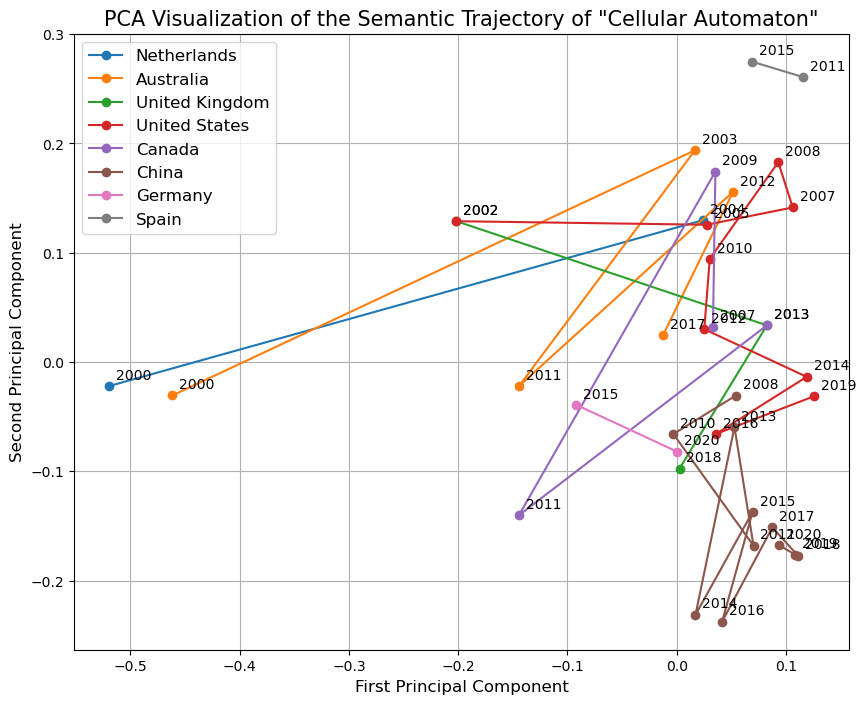

In [68]:
plot_keyword_trajectory_matplotlib(top_10_df, 'cellular automaton')

## cosine similarity

In [17]:
def find_similar_keywords(df, target_keyword, target_year, target_country, n=5):
    
    # Get the target embedding
    target_row = df[(df['Author Keywords'] == target_keyword) & 
                    (df['Year'] == target_year) & 
                    (df['Country'] == target_country)]
    
    if len(target_row) == 0:
        return f"No data found for {target_keyword} in {target_country}, {target_year}"
    
    target_embedding = target_row['Combined_E'].iloc[0]
    
    # Get rows from all other years
    other_rows = df[df['Year'] != target_year]
    
    # Calculate similarities
    similarities = []
    for _, row in other_rows.iterrows():
        similarity = cosine_similarity(
            target_embedding.reshape(1, -1),
            row['Combined_E'].reshape(1, -1)
        )[0][0]
        
        similarities.append((
            row['Author Keywords'],
            similarity,
            row['Year'],
            row['Country']
        ))
    
    # Sort by similarity and get top n
    most_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[:n]
    
    return most_similar

In [34]:
target_keyword ='urban planning'
year = 2019
country = 'China'
similar_keywords = find_similar_keywords(concept_rep, target_keyword, year, country)

print(f"Most similar keywords to {target_keyword} in {country}, {year}:")
for keyword, sim, year, country in similar_keywords:
    print(f"{keyword} ({country}, {year}): {sim:.3f}")

Most similar keywords to urban planning in China, 2019:
urban spatial dynamic (China, 2020): 0.953
scenario planning (China, 2020): 0.948
urban land use (China, 2020): 0.948
geospatial big data (China, 2018): 0.945
planning support system (China, 2020): 0.945


In [30]:
target_keyword ='urban planning'
year = 2008
country = 'United Kingdom'
similar_keywords = find_similar_keywords(concept_rep, target_keyword, year, country)

print(f"Most similar keywords to {target_keyword} in {country}, {year}:")
for keyword, sim, year, country in similar_keywords:
    print(f"{keyword} ({country}, {year}): {sim:.3f}")

Most similar keywords to urban planning in United Kingdom, 2008:
urban planning (New Zealand, 2015): 0.917
urban planning (United Kingdom, 2019): 0.916
agent based model (United Kingdom, 2019): 0.915
decision making (Switzerland, 2017): 0.914
sound environment (Switzerland, 2017): 0.914


In [31]:
target_keyword ='urban planning'
year = 2019
country = 'United Kingdom'
similar_keywords = find_similar_keywords(concept_rep, target_keyword, year, country)

print(f"Most similar keywords to {target_keyword} in {country}, {year}:")
for keyword, sim, year, country in similar_keywords:
    print(f"{keyword} ({country}, {year}): {sim:.3f}")

Most similar keywords to urban planning in United Kingdom, 2019:
gis (United Kingdom, 2005): 0.934
urban layout (United Kingdom, 2011): 0.924
urban planning (France, 2018): 0.923
global positioning system (Egypt, 2012): 0.921
remote sensing (South Africa, 1995): 0.920


In [38]:
target_keyword ='urban planning'
year = 2004
country = 'Australia'
similar_keywords = find_similar_keywords(concept_rep, target_keyword, year, country)

print(f"Most similar keywords to {target_keyword} in {country}, {year}:")
for keyword, sim, year, country in similar_keywords:
    print(f"{keyword} ({country}, {year}): {sim:.3f}")

Most similar keywords to urban planning in Australia, 2004:
urban planning (Finland, 2020): 0.947
urban planning (United States, 1998): 0.937
urban planning (Netherlands, 2016): 0.936
regional planning (Portugal, 2013): 0.931
regional planning (Croatia, 2013): 0.931


In [37]:
target_keyword ='urban planning'
year = 2018
country = 'Australia'
similar_keywords = find_similar_keywords(concept_rep, target_keyword, year, country)

print(f"Most similar keywords to {target_keyword} in {country}, {year}:")
for keyword, sim, year, country in similar_keywords:
    print(f"{keyword} ({country}, {year}): {sim:.3f}")

Most similar keywords to urban planning in Australia, 2018:
urban data (United States, 2019): 0.928
urban land use change (United Kingdom, 2014): 0.927
urban scaling law (Europe, 2020): 0.924
urban planning (United States, 2019): 0.924
residential mobility (United Kingdom, 2014): 0.921


In [20]:
concept_rep[
    (concept_rep['Author Keywords'] == 'urban planning') # & (concept_rep['Year'] == 2000)
]

,Year,Country,Author Keywords,Combined_E
452,2003,Brazil,urban planning,"[-0.00428201, 0.00791827, 0.0017215046, 0.0092..."
495,2004,United States,urban planning,"[-0.0021415818, 5.9824553e-05, -0.006451191, 0..."
499,2004,Australia,urban planning,"[-0.0021415818, 5.9824553e-05, -0.006451191, 0..."
996,2008,United Kingdom,urban planning,"[-0.028417664, -0.0048977216, 0.024523877, -0...."
1381,2011,China,urban planning,"[-0.028153647, -0.015129767, 0.008379096, 0.01..."
1488,2012,Germany,urban planning,"[-0.011652488, 0.011618797, 0.027043328, 0.004..."
2185,2015,United States,urban planning,"[-0.014779497, -0.01645688, 1.40634365e-05, 0...."
2701,2017,Spain,urban planning,"[-0.009929676, -0.016739681, -0.010961082, 0.0..."
2893,2018,France,urban planning,"[-0.013664154, -0.010664102, 0.0039034635, 0.0..."
2978,2018,United States,urban planning,"[0.009166434, -0.020642702, -0.015137283, 0.01..."
